# Collision times for cyclists and pedestrians in key locations in Oxford 

This work is to help inform discussions about the operational times of any new bus gates installed in the city via COTS. 

It uses the following data sources:

- Road traffic collision data from https://bikedata.cyclestreets.net (which reformatted version of [UK road safety data](https://www.data.gov.uk/dataset/cb7ae6f0-4be6-4935-9277-47e5ce24a11f/road-safety-data))
- (maybe) some baseline cyclists and pedestrian numbers from data scraped from https://oxbike.co.uk/ 

## TODO

- :heavy_check_mark: Select locations to analyse, given potential COTS bus gate locations
- :heavy_check_mark: Get datasets from these locations
- :heavy_check_mark: Pull out time of day information
- :heavy_check_mark: Graph this information
- Potentially normalise with baseline data from oxbike.co.uk

## Locations to analyse

### Potential bus gate locations

- Hythe Bridge Street
- St Clements
- St Cross Street
- Hollow Way 
- Marston Ferry Road

### Roads / junctions to analyse 

- The Plain (`01_the_plain.csv`)
- High Street, Longwall junction and down to Plain (not including the Plain) (`02_high_street.csv`)
- St Clement's / Headington Road, up to Headley Way (including that junction) (`03_st_clements.csv`)
- Cowley Road, upto the Church Cowley Road (including that junction) (`04_cowley_road.csv`)
- Iffley Road, upto junction with Church Cowley Road (including that junction) (`05_iffley_road.csv`)
- Hollow Way (`06_hollow_way.csv`)
- Marston Ferry Road/Cherwell Drive (`07_marston_ferry_road.csv`)
- A4144 from station to St Giles Road (`08_hythe_bridge_street.csv`)

### Lower priority locations to analyse

- London Road (upto but not including the junction with Headley Way)
- Iffley Road south of Church Cowley Road (upto but not including the junction with Church Cowley Road)
- Church Cowley Road 
- Morrell Avenue/Warneford Lane/Old Road (upto the junction with the Slade)
- The Slade 
- Windmill Road 

### Getting data from https://bikedata.cyclestreets.net

There is a dragging tool for extracting data from the map. 

- Drag around each road / junction (make a judgement call RE boundaries as sometimes the lat/longs are a bit off so you have to *e.g.* go wider round the road at points)
- Select the widest possible date range (1999-2020) and export as spreadsheet. 
- Note there is a limit of 400 data points per export one has to extract in chunks by batching up by date. 
- Difficult to tease apart *e.g.* what is "Iffley Road" and what is "The Plain", made a judgement call by looking at the map. 


Get some distances (from Google maps), in kilometres, for each of these stretches of road. This will be useful to normalise the data later. 

In [1]:
import datetime 
import pathlib

import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
distances = {
    '01_the_plain': 0.1,
    '02_high_street': 1.0,
    '03_st_clements': 1.9,
    '04_cowley_road': 2.8,
    '05_iffley_road': 2.2,
    '06_hollow_way': 1.3,
    '07_marston_ferry_road': 2.5,
    '08_hythe_bridge_street': 0.85,
}

In [3]:
road_list = list(distances.keys())

In [4]:
data_dir = pathlib.Path.cwd().parent.joinpath("data/key_roads")

In [5]:
# Define function for processing the data for each road 
def read_road_data(filename: str) -> pd.DataFrame:
    df = pd.read_csv(data_dir.joinpath(filename))
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    return df

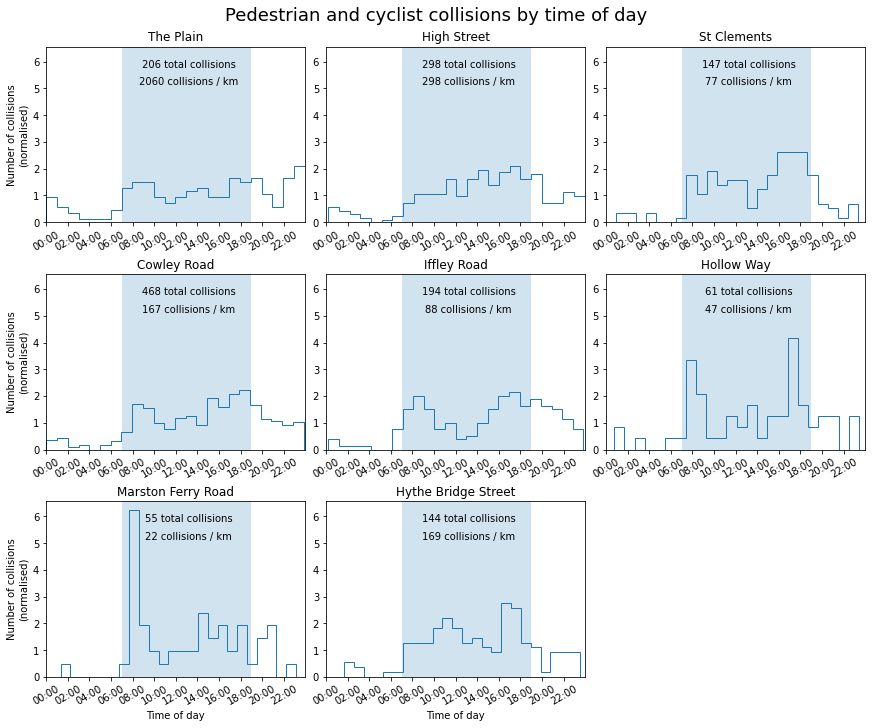

In [6]:
# Plot time of day histograms for each road
fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharex=True, sharey=True, constrained_layout=True)

for ax, road in zip(axes.flat, road_list):
    df = read_road_data(road + '.csv')
    ax.set_title(' '.join(road.split('_')[1:]).title())

    # Set all of the dates to be the same to make plotting the time of day easier
    times_of_day = df['Timestamp'].apply(lambda x: x.replace(year=2000, month=1, day=1)).tolist()

    ax.hist(times_of_day, bins=24, histtype='step', density=True)

    num_collisions = len(df)
    collisions_per_km = num_collisions / distances[road]

    ax.text(
        0.55,
        0.9,
        f'{num_collisions} total collisions',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes,
    )

    ax.text(
        0.55,
        0.8,
        f'{collisions_per_km:.0f} collisions / km',
        horizontalalignment='center',
        verticalalignment='center',
        transform=ax.transAxes,
    )

    ax.xaxis_date()
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlim([datetime.datetime(2000, 1, 1, 0, 0, 0), datetime.datetime(2000, 1, 1, 23, 59, 59)])
    ax.xaxis.set_tick_params(labelbottom=True, labelrotation=30)
    ax.yaxis.set_tick_params(labelleft=True)

    # Shade region of proposed bus gate operation
    ax.axvspan(datetime.datetime(2000, 1, 1, 7, 0, 0), datetime.datetime(2000, 1, 1, 19, 0, 0), alpha=0.2)

# We only have eight roads so we delete the last plot and manually rotate the x-axis in the plot above
# (Since we are using sharex=True)
axes[2][2].set_axis_off()
# axes[1][2].xaxis.set_tick_params(which='both', labelbottom=True, labelrotation = 30)

plt.setp(axes[-1, :], xlabel='Time of day')
plt.setp(axes[:, 0], ylabel='Number of collisions\n(normalised)')
plt.setp(ax.get_xticklabels(), visible=True)

plt.suptitle('Pedestrian and cyclist collisions by time of day', fontsize=18)

plt.show()